# 1. gensim, numpy 패키지 업그레이드 및 구글드라이브 마운트

In [ ]:
!pip install --upgrade gensim
!pip install --upgrade numpy

     |████████████████████████████████| 24.0 MB 1.2 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 15.7 MB 4.2 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.2 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive',force_remount=True)

path = '/content/drive/My Drive/word_embedding'
os.chdir(path)
os.getcwd()

Mounted at /content/drive


'/content/drive/My Drive/word_embedding'

# 2. Word2Vec BaseLine

In [ ]:
import pandas as pd
import re
from tqdm import tqdm
corpus_path = './data/wiki_ko_mecab.txt'

datasets = []
with open(corpus_path, 'r', encoding='utf-8') as f:
    for line in tqdm(f):
        datasets.append(re.sub(r"[^ㄱ-힣a-zA-Z0-9]+", ' ', line).strip().split())

311237it [01:49, 2836.30it/s]


In [ ]:
# Word2Vec BaseLine
import time
from gensim.models import Word2Vec, KeyedVectors

start_time = time.time()
model_name = './wiki-sg-256.wv'
model = Word2Vec(datasets, vector_size=256, workers=12, sg=1, window=5, min_count=10)
word_vectors = model.wv
word_vectors.save_word2vec_format(model_name) # 파일 저장
end_time = time.time()
print('실행시간 : ',end_time - start_time)

실행시간 :  3686.5160434246063


In [ ]:
# 테스트 데이터 다운로드
!wget https://raw.githubusercontent.com/dongjun-Lee/kor2vec/master/test_dataset/kor_ws353.csv

--2021-09-07 04:56:03--  https://raw.githubusercontent.com/dongjun-Lee/kor2vec/master/test_dataset/kor_ws353.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6753 (6.6K) [text/plain]
Saving to: ‘kor_ws353.csv’

kor_ws353.csv       100%[===================>]   6.59K  --.-KB/s    in 0.001s  

2021-09-07 04:56:04 (4.57 MB/s) - ‘kor_ws353.csv’ saved [6753/6753]



In [ ]:
# 유사성 결과를 반환하는 함수
def get_result(model):
  testset = './kor_ws353.csv'
  answer_list, pred_list = [], []
  with open(testset, 'r', encoding='utf-8-sig') as testfile:
      for pair in testfile:
          w1, w2, sim = pair.strip().split(',')
          try:
              pred = model.wv.similarity(w1, w2)
              answer_list.append(float(sim))
              pred_list.append(pred)
          except KeyError as e:
              # 단어 임베딩에 포함되지 않은 단어들
              print(e)
      return answer_list, pred_list

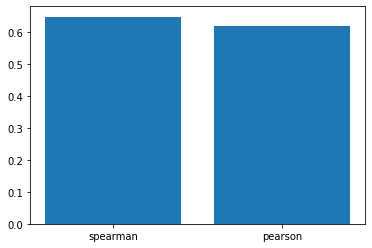

spearman: 0.64861, pearson: 0.61919


In [ ]:
# 유사성 결과 시각화 (상관계수)
from scipy import stats
from matplotlib import pyplot as plt

spearman, _ = stats.spearmanr(answer_list, pred_list)
pearson, _ = stats.pearsonr(answer_list, pred_list)

label = ['spearman','pearson']
plt.bar(label, [spearman, pearson])
plt.show()
print('spearman: %.5f, pearson: %.5f' % (spearman, pearson))

# 3. FastText 알고리즘

In [ ]:
# 큰 데이터 셋을 한줄씩 처리하여 알고리즘에 전달
from gensim.utils import tokenize
from gensim import utils
import re

class MyIter:
    def __init__(self, path):
      self.path = path
    def __iter__(self):
      with utils.open(self.path, 'r', encoding='utf-8') as fin:
        for line in fin:
          yield list(tokenize(re.sub(r"[^ㄱ-힣a-zA-Z0-9]+", ' ', line).strip()))

실행시간 :  22997.067088127136


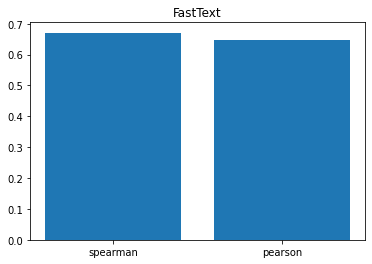

spearman: 0.67099, pearson: 0.64703


In [ ]:
from gensim.models import FastText

import time

start_time = time.time()
fast_text_model = FastText(vector_size=300, workers=36, sg=1, window=10, negative=2)
fast_text_model.build_vocab(corpus_iterable=MyIter('./data/wiki_ko_mecab.txt'))
total_examples = fast_text_model.corpus_count
fast_text_model.train(corpus_iterable=MyIter('./data/wiki_ko_mecab.txt'), total_examples=total_examples, epochs=20)
fname = 'wiki-sg1-300-epochs20.ft'
fast_text_model.save(fname)
end_time = time.time()
print('실행시간 : ',end_time - start_time)

answer_list, pred_list = get_result(fast_text_model)
from scipy import stats
from matplotlib import pyplot as plt

spearman, _ = stats.spearmanr(answer_list, pred_list)
pearson, _ = stats.pearsonr(answer_list, pred_list)

label = ['spearman','pearson']
plt.bar(label, [spearman, pearson])
plt.title('FastText')
plt.show()
print('spearman: %.5f, pearson: %.5f' % (spearman, pearson))

# 4시간 23분

# 4. 단어 임베딩 시각화 (t-SNE) 단어 200개

In [ ]:
from gensim.models import FastText
from sklearn.manifold import TSNE
import gensim.models as g

# 단어 보여줄 개수
SIZE = 200

# 저장된 모델 로드
fast_text_model = FastText.load('wiki-sg1-300-epochs20.ft')

# 단어 리스트
vocab = [word for word in fast_text_model.wv.key_to_index]
# 단어에 대한 벡터값
X = fast_text_model.wv[vocab]

# t-SNE를 통해 2차원 변환
word_embedded = TSNE(n_components=2).fit_transform(X[:SIZE,:])
word_embedded.shape

(200, 2)

In [ ]:
import pandas as pd
df = pd.DataFrame(word_embedded, index=vocab[:SIZE],columns=['x','y'])
df

,x,y
의,2.671720,-2.071035
이,1.478634,-2.415034
다,1.626734,-2.306270
는,0.846790,-2.493723
년,4.297894,1.171116
...,...,...
전쟁,-3.481724,-1.907606
TV,7.559480,4.189809
프랑스,9.638155,-2.012364
뒤,-4.687943,0.161451


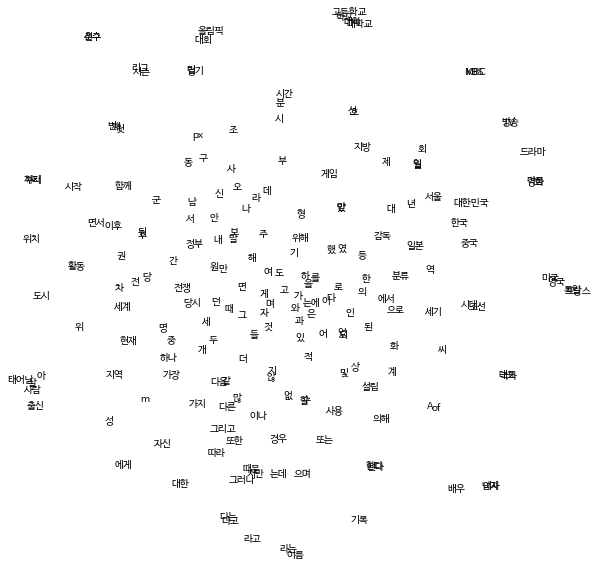

In [ ]:
import matplotlib.pyplot as  plt
import matplotlib as mpl

mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='NanumBarunGothic')

fig,ax = plt.subplots(1, 1, figsize=(10, 10))
plt.xlim(df.loc[:,'x'].min(), df.loc[:,'x'].max())
plt.ylim(df.loc[:,'y'].min(), df.loc[:,'y'].max())
plt.axis('off')
for word, pos in df.iterrows():
  plt.text(pos[0],pos[1], word)
plt.show()